## Word Embedding

### Representing text as numbers

Machine learning models take vectors as input. When working with text, the first thing that's need to be done is to come up with a strategy to convert strings to numbers ("vectorizing" the text) before feeding it to the model.

#### One-hot encodings

Consider the sentence "The cat sat on the mat". The vocabulary (unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word.

|     |    | cat | mat | on | sat | the |
|-----|----|-----|-----|----|-----|-----|
| the | => | 0   | 0   | 0  | 0   | 1   |
| cat | => | 1   | 0   | 0  | 0   | 0   |
| sat | => | 0   | 0   | 0  | 1   | 0   |
| on  | => | 0   | 0   | 1  | 0   | 0   |
| the | => | 0   | 0   | 0  | 0   | 1   |
| mat | => | 0   | 1   | 0  | 0   | 0   |

To create a vector that contains the encoding of the sentence, concatenate the one-hot vectors for each word.

This approach is inefficient. A one-hot encoded vector is sparse (most indices are zero) which will add up the space complexity of the design.

#### Encode each word with a unique number

A second approach would be using a unique number. The sentence "The cat sat on the mat" can be encoded as a dense vector like [5, 1, 4, 3, 5, 2]. This approach is efficient. However:
- The integer-encoding is arbitrary (does not capture any relationship between words aka losing features)
- An integer-encoding can be challenging model to interpret because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand.
An embedding is a dense vector of floating point values (the length of the vector is the parameter that will be specified). Instead of specifying the values for the embedding manually, they are trainable parameters (weigths learned by the model during training, in the same way a model learns weight for dense layer).
It is common to see word embeddings that are 8 to 1024-dimensions. Ahigher dimensional embedding can capture fine-grained relationships between words, butake more data to learn.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

### Embedding layer

Embedding layer can be understood as a lookup table that maps from integer indices (which represent specific words) to dense vectors (their embeddings). The dimensionality (width) of the embedding is a paramerter that can be experimented to see what works for the problem.

In [2]:
# largest integer/word index/vocabulary size in the input should 
# be no more than 999
# embedding_layer.output_shape == (None, input_length, 5) where
# None is the batch dimension
embedding_layer = layers.Embedding(1000, 5)

When embedding layer is created, the weight of the embedding are randomly initialized. During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words.

If integer is passed to an embedding layer, the result replaces each integer with the vector from the embedding table as shown below.

In [3]:
result = embedding_layer(tf.constant([1, 2, 3]))
print(result.numpy())

[[-0.02250582  0.02973874 -0.01462626  0.01839112 -0.019164  ]
 [ 0.04875505  0.04100648 -0.0094316  -0.01796307  0.0039238 ]
 [ 0.01429209  0.03127908 -0.03365175  0.00463424 -0.03576794]]


For text or sequence problems, the embedding layer takes a 2D tensor of integers, of shape ```(samples, sequence_length)``` where each entry is a sequence of integers. It can be embed sequences of variable lengths.

WE could feed into the embedding layer above batches with shapes ```(32, 10)``` (batch of 32 with sequences of length 10) or ```(64, 15)``` (batch of 64 with sequence length of 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis.

In [7]:
tensor = tf.constant([
   [0, 1, 2],
   [3, 4, 5]
])

print("Tensor shape: ", tensor.shape)

result = embedding_layer(tensor)
print("Result shape: ", result.shape)

Tensor shape:  (2, 3)
Result shape:  (2, 3, 5)


When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor of shape ```(samples, sequence_length, embedding_dimensionality)```.
To convert from this sequence of variable length to a fixed representation, there are variety of standard approaches. RNN, Attention or pooling layer could be used before passing it to a Dense layer. Pooling emthod will be used here.

### Learning embedding from scratch

Train a sentiment classifier on IMDB movie reviews. In this process, the model will learn embeddings from scratch.

In [8]:
(train_data, test_data), info = tfds.load(
   "imdb_reviews/subwords8k",
   split = (tfds.Split.TRAIN, tfds.Split.TEST),
   with_info = True,
   as_supervised = True
)

Get encoder ```tfds.features.text.SubwordTextEncoder``` and have a quick look at the vocabulary.

The "\_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "\_") and partial words which it can use to build larger words:

In [9]:
encoder = info.features["text"].encoder
print(encoder.subwords[:20])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']


In [31]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

As each sentence can be different lengths, ```padded_batch``` method will be used to standardize the lengths of the reviews.

#### Changes from tf2 with tf_nightly

```padded_batch``` require ```padded_shape``` positional arguments. As from ```tfds.load``` input argument ```as_supervised:False``` if ```True``` the returned ```tf.data.Dataset``` will have 2-tuple structure ```(input, label)``` according to ```builder.info.supervised_keys```. If ```False```, the default value, the returned ```tf.data.Dataset``` will have a dictionary with all the features.

In [32]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = ([None], []))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = ([None], []))

As imported, the text of reviews is integer-encoded where each integer represents a specific word or word-part in the vocabulary. Note the trailing zeros, because the batch is padded to the longest example.

In [35]:
train_batch, train_labels = next(iter(train_batches))
print(train_batch.numpy())

[[  19 1059  903 ...    6 7895 7975]
 [ 433 4101  331 ...    0    0    0]
 [  12  393    1 ...    0    0    0]
 ...
 [8002 1383 3856 ...    0    0    0]
 [ 134   82 1133 ...    0    0    0]
 [  62    9    4 ...    0    0    0]]


### Model - Continuous bag of words

- Next the ```Embedding``` layer takes the interger-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as model trains. Vectors add a dimensio to the output array. The resulting dimensions are ```(batch, sequence, embedding)```
- ```GlobalAveragePooling1D``` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allos the model to handle input of variable length in the simplest way possible.
- This fixed-length output vector is piped through a fully-connected ```Dense``` layer with 16 hidden units.
- The last layer is densely connected with a single output node. Using the ```sigmoid``` activation function, this value is float between [0, 1] representing a probability/confidence level that the review is positive.

This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.

In [37]:
embedding_dim = 16

model = keras.Sequential([
   layers.Embedding(encoder.vocab_size, embedding_dim),
   layers.GlobalAveragePooling1D(),
   layers.Dense(16, activation = "relu"),
   layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(
   optimizer='adam',
   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
   metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.5106 - accuracy: 0.6925 - val_loss: 0.3639 - val_accuracy: 0.8450
Epoch 2/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2828 - accuracy: 0.8832 - val_loss: 0.4000 - val_accuracy: 0.8550
Epoch 3/10
2500/2500 [==============================] - 11s 5ms/step - loss: 0.2301 - accuracy: 0.9106 - val_loss: 0.3418 - val_accuracy: 0.8900
Epoch 4/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1969 - accuracy: 0.9254 - val_loss: 0.5105 - val_accuracy: 0.8300
Epoch 5/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1733 - accuracy: 0.9356 - val_loss: 0.3232 - val_accuracy: 0.8750
Epoch 6/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1566 - accuracy: 0.9424 - val_loss: 0.2748 - val_accuracy: 0.9000
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1440 - accuracy: 0.9473 - val_loss: 0.3925 - val_accu

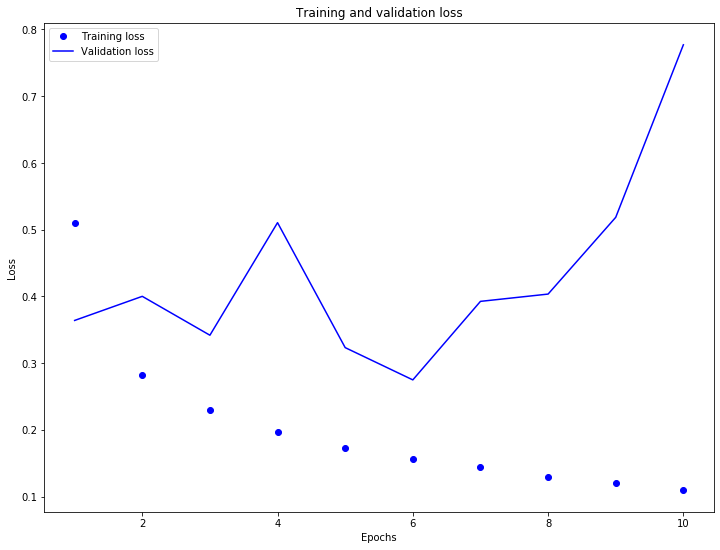

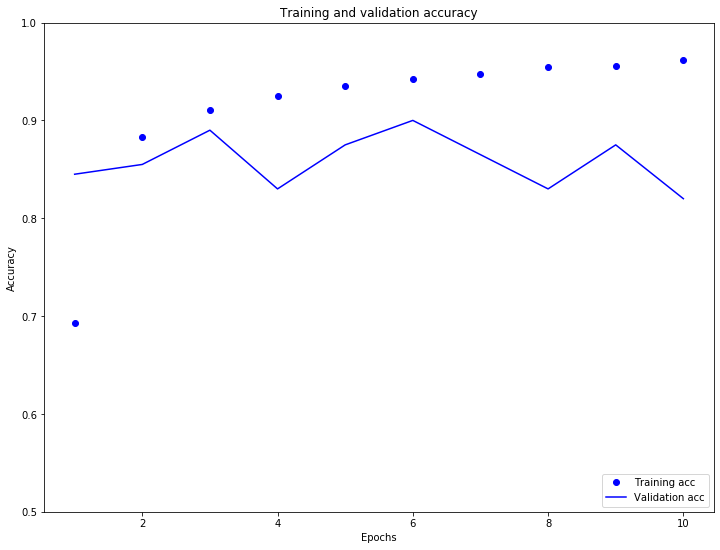

In [39]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

### Retrieve the learned embeddings

The word embeddings learned during training will be a matrix of shape ```(vocab_size, imbedding-dimension)```

In [41]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)
